# User Guide

In [1]:
from hydrodata import Station, MatchCRS
from pygeoogc import ArcGISRESTful, WFS
import pygeoogc as ogc
import hydrodata.datasets as hds
from hydrodata import plot, utils
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Datasets

To get started, we get the information for a USGS station using `Station` class. First, lets explore the available USGS stations and select one. `interactive_map` function from `utils` can be used to find all the stations within a bounding box.

In [3]:
hds.interactive_map((-70, 44, -69, 46))

In [4]:
wshed = Station(station_id='01031500')

### NHDPlus

Then, using the watershed geometry we can use the `datasets` module to access other databases. Lets start by the main upstream river channel, the tributatires upstream, catchments for each river segment, and all USGS stations up to 150 km upstream of the main river channel using `NLDI` class.

In [5]:
tributaries = wshed.flowlines()
main_channel = wshed.flowlines(navigation="upstreamMain")
catchments = wshed.catchments()
stations = wshed.nwis_stations(navigation="upstreamMain", distance=150)

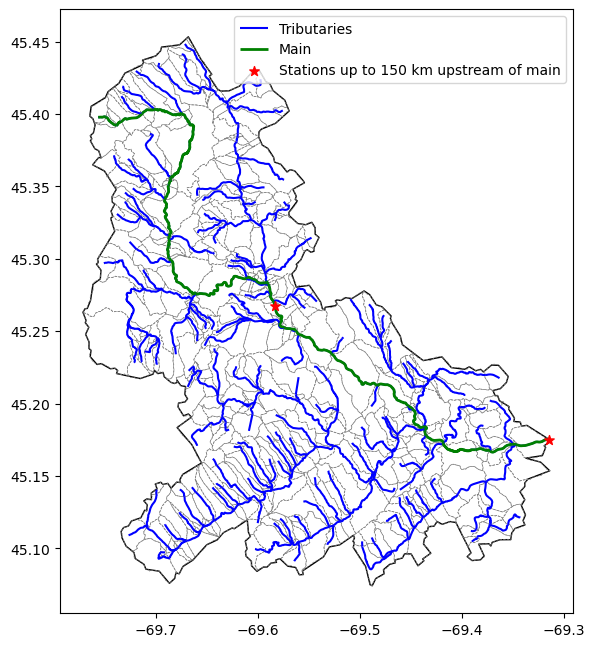

In [6]:
ax = wshed.basin.plot(facecolor='none', edgecolor='k', figsize = (8, 8))
catchments.plot(ax=ax, facecolor='none', edgecolor='grey', ls= "--", lw=0.5, zorder=1)
tributaries.plot(ax=ax, color='b', label='Tributaries', zorder=2)
main_channel.plot(ax=ax, color='g', lw=2, label='Main', zorder=3)
stations.plot(ax=ax, color='r', label='Stations up to 150 km upstream of main', marker='*', zorder=4, markersize=50)
ax.figure.set_dpi(100)
ax.legend(loc='best');

### NWIS

The daily mean streamflow data can be retrieved from NWIS service.

In [7]:
dates = ("2000-01-01", "2010-01-21")
qobs = hds.nwis_streamflow(wshed.station_id, dates)

### Daymet

The climate data at the location of the station can be retrieved from Daymet. Additionally, we can get Potential EvapoTranspiration based on the Daymetdata using the `pet` flag. Data can be downloaded for both a single pixel and gridded.

In [8]:
variables = ["tmin", "tmax", "prcp"]
clm_p = hds.daymet_byloc(wshed.coords, dates=dates, variables=variables, pet=True)
clm_g = hds.daymet_bygeom(wshed.geometry, dates=('2005-01-01', '2005-01-31'), variables=variables, pet=True)

### SSEBop

The daily actual evapotranspiration can be retrieved from SEEBop database. Note that since this service does not offer a web service and data are available as raster files on the server, this function is not as fast as other functions and download speed might be the bottleneck. Data can be downloaded for both a single pixel and gridded.

In [9]:
dates = ('2005-01-01', '2005-01-10')
eta_p = hds.ssebopeta_byloc(wshed.coords, dates=dates)
eta_g = hds.ssebopeta_bygeom(wshed.geometry, dates=dates)

### DEM

DEM, slope (in m/m rather than degrees), and aspect can be retrieved for the station's contributing watershed at 30 m resolution, as follows:

In [10]:
nm = hds.NationalMap(wshed.geometry, resolution=30)
dem, slope, aspect = nm.get_dem(), nm.get_slope(mpm=True), nm.get_aspect()

### NLCD

Land cover, imperviousness, and canopy data are retrieved from NLCD.

In [11]:
lulc = hds.nlcd(wshed.geometry, years={'impervious': 2016, 'cover': 2016, 'canopy': 2016}, resolution=1e3)

### Web Mapping Services

Three tools are provided in `services` module for adding databases that are not available in Hydrodata; `ArcGISRESTful` for adding ArcGIS RESTful-based services, `wms_bygeom` for WMS-based services, and `wfs_bygeom` for WFS-based services. For example, lets use ``services`` module for accessing [Watershed Boundary Dataset](https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer) RESTful service, [National Wetlands Inventory](https://www.fws.gov/wetlands/) via WMS, and [FEMA National Flood Hazard Layer](https://www.fema.gov/national-flood-hazard-layer-nfhl) via WFS for a watershed in Los Angeles:

In [12]:
la_wshed = Station('11092450')

wbd8 = ArcGISRESTful(base_url="https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/4")
wbd8.n_threads = 4
wbd8.get_featureids(la_wshed.geometry.bounds)
wbd8.get_featureids(la_wshed.geometry)
resp = wbd8.get_features()
huc8 = utils.json_togeodf(resp)

url_wms = "https://www.fws.gov/wetlands/arcgis/services/Wetlands_Raster/ImageServer/WMSServer"
layer = "0"
r_dict = ogc.wms_bybox(
    url_wms,
    layer,
    la_wshed.geometry.bounds,
    1e3,
    "image/tiff",
    box_crs="epsg:4326",
    crs="epsg:3857",
)
geom = MatchCRS.geometry(la_wshed.geometry, "epsg:4326", "epsg:3857")
wetlands = utils.wms_toxarray(r_dict, geom, "epsg:3857")

url_wfs = "https://hazards.fema.gov/gis/nfhl/services/public/NFHL/MapServer/WFSServer"
wfs = WFS(
    url_wfs,
    layer="public_NFHL:Base_Flood_Elevations",
    outformat="esrigeojson",
    crs="epsg:4269",
)
r = wfs.getfeature_bybox(la_wshed.geometry.bounds, box_crs="epsg:4326")
flood = utils.json_togeodf(r.json(), "epsg:4269", "epsg:4326")

## Plotting

All the gridded data are returned as [xarray](https://xarray.pydata.org/en/stable/) datasets and data arrays that has efficient data processing tools. Note that Daymet dataset's projection is [Lambert](https://daymet.ornl.gov/overview). For the land cover data, a helper function exists called `cover_legends` that provide the official colors and legends for plotting.

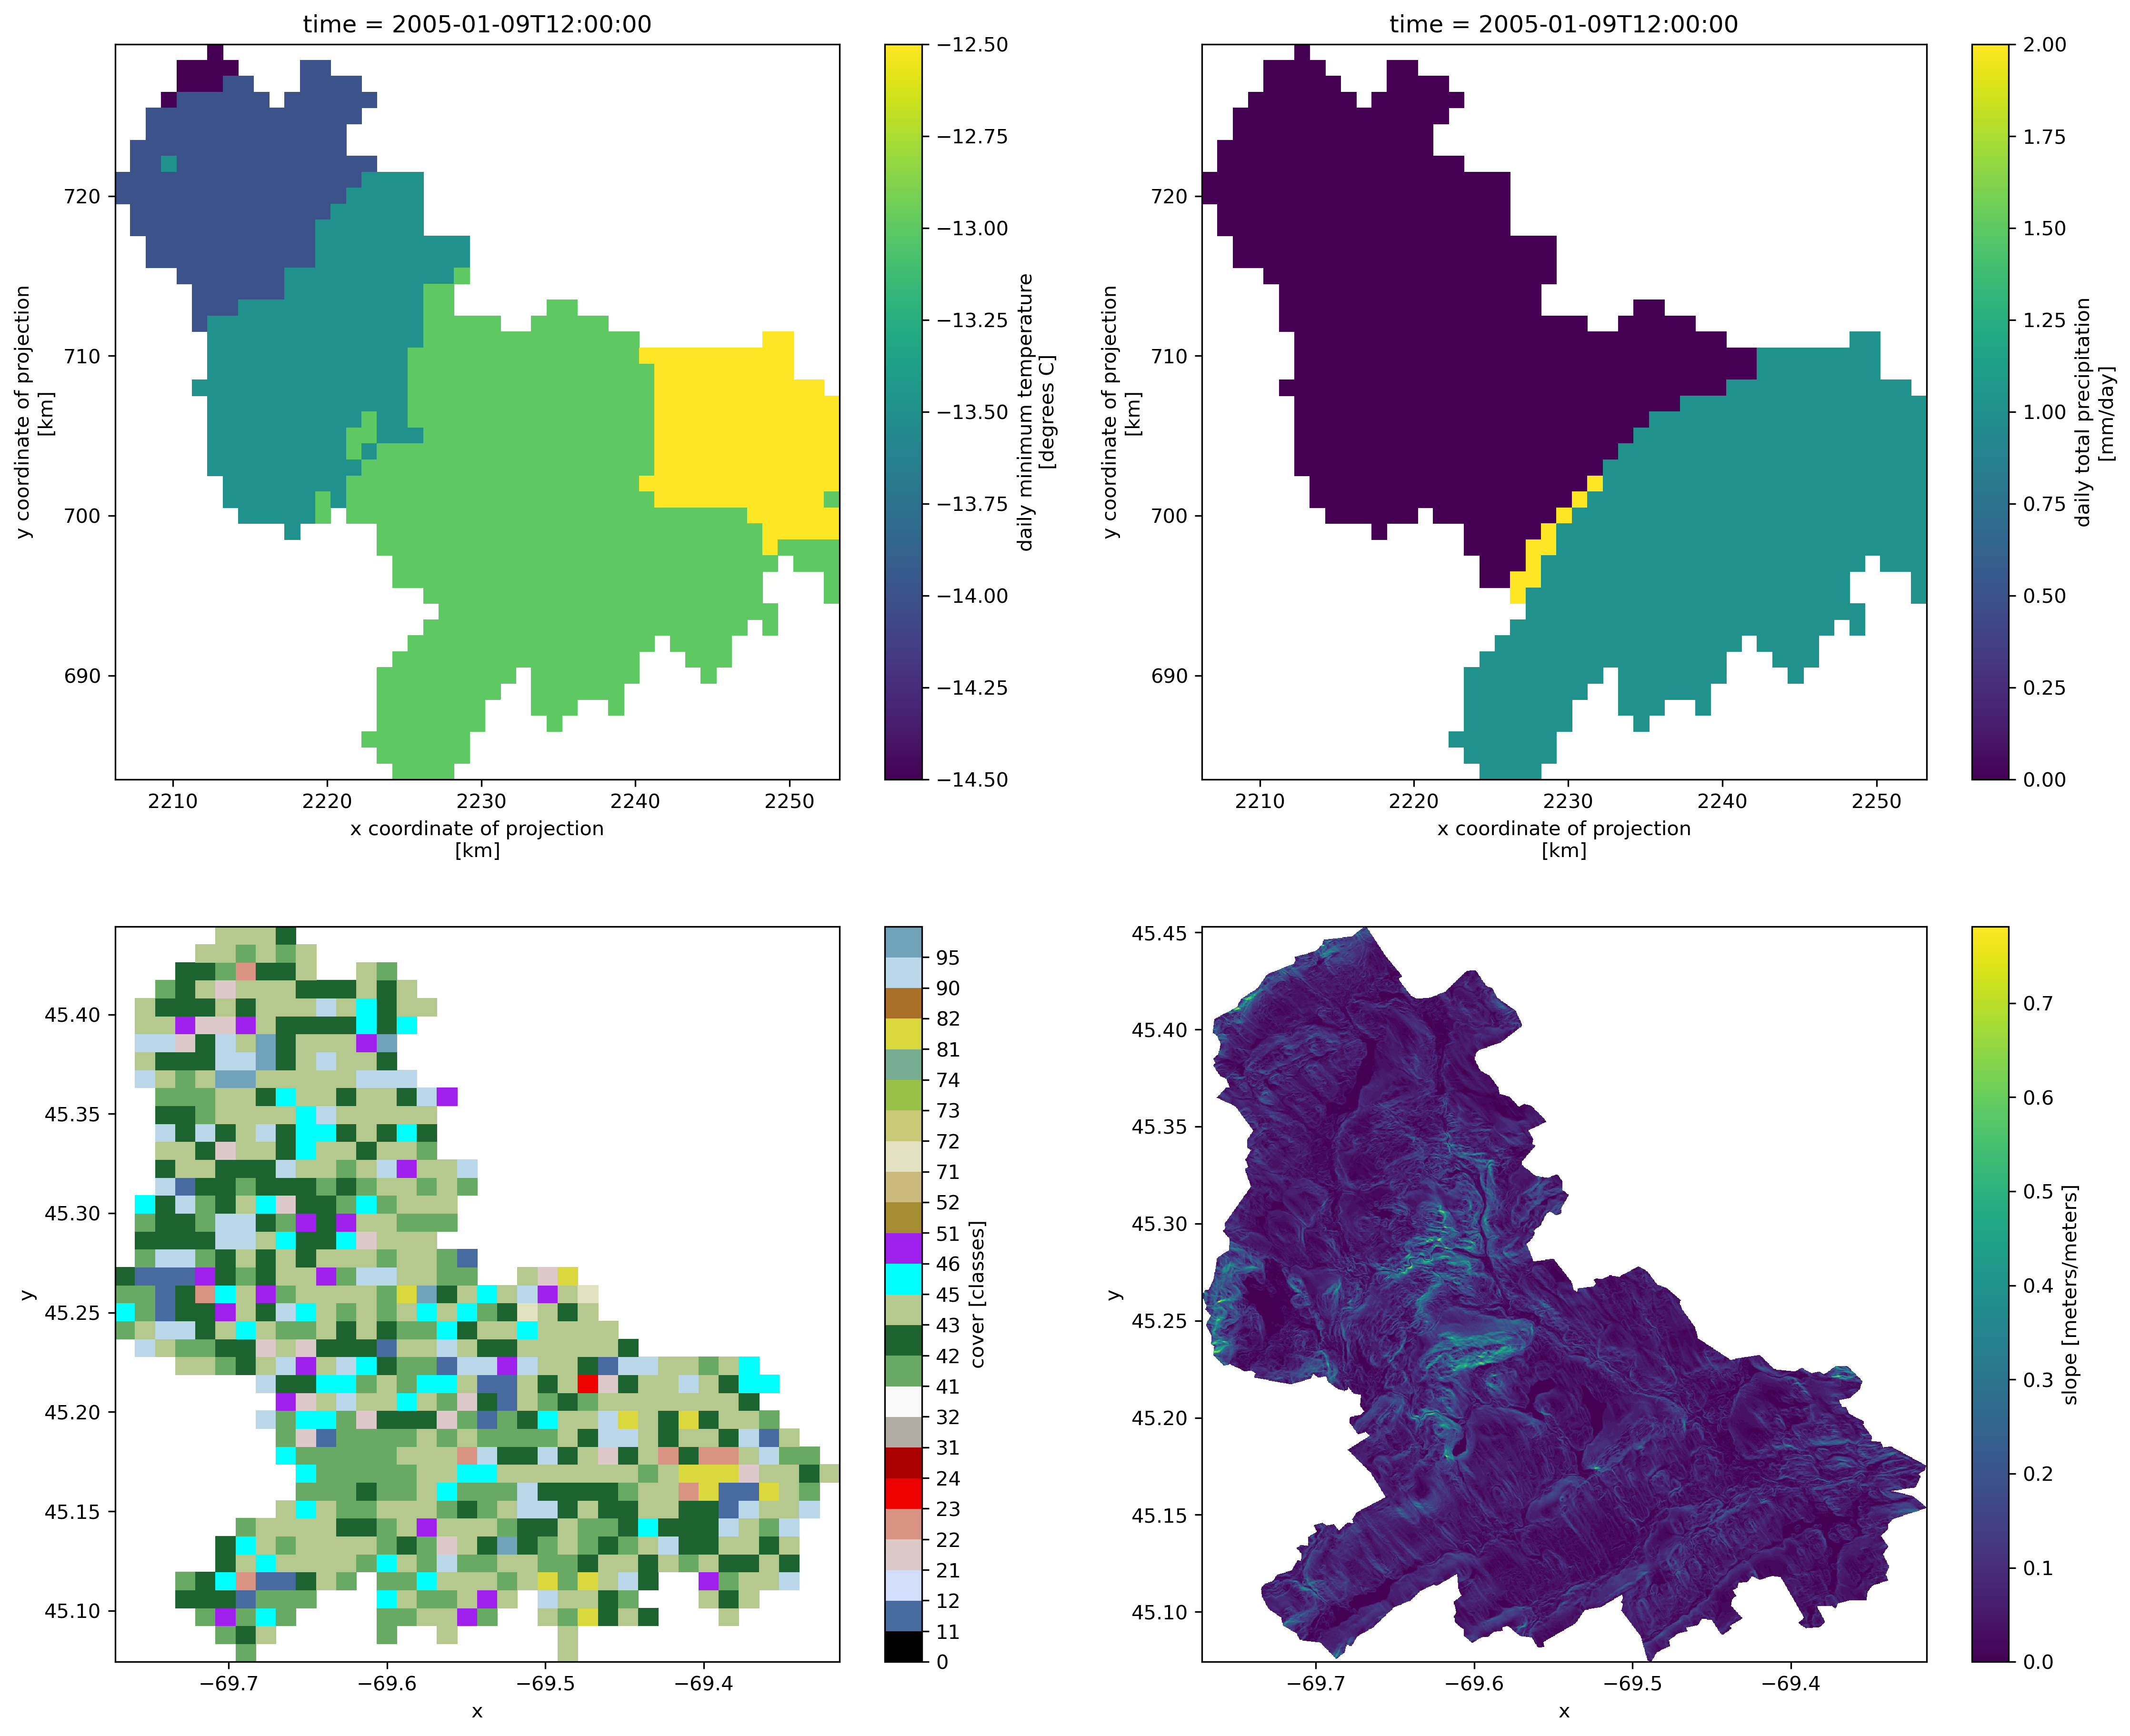

In [13]:
cmap, norm, levels = plot.cover_legends()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 15))
clm_g.tmin.isel(time=8).plot(ax=axes[0, 0])
clm_g.prcp.isel(time=8).plot(ax=axes[0, 1])
lulc.cover.plot(ax=axes[1, 0], cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]})
slope.plot(ax=axes[1, 1])
fig.set_dpi(300);

Moreover, `signatures` function in `plot` module, plots the hydrologic signatures graphs. It is noted that this function uses the column names of the input dataframe (``qobs`` in the example below) as legends.

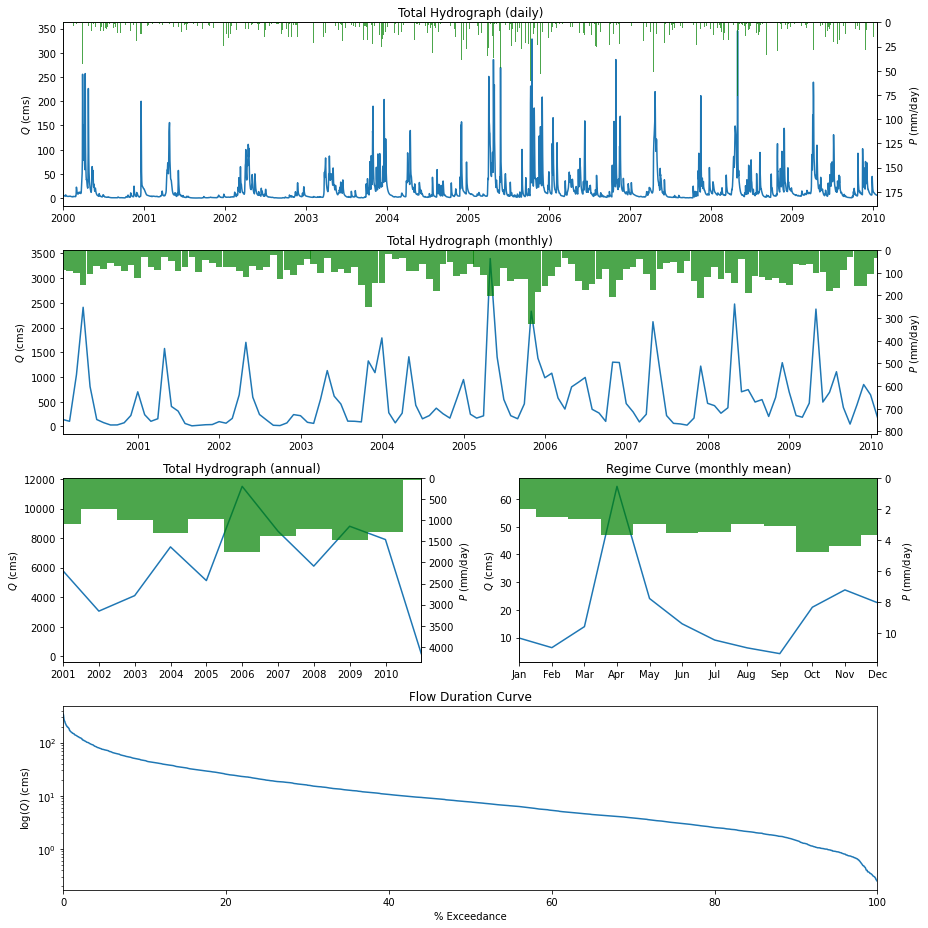

In [14]:
plot.signatures(qobs[f"USGS-{wshed.station_id}"], precipitation=clm_p["prcp (mm/day)"])

## Flow Accumulation

Based on topological sorting of a river network ``utils.vector_accumulation`` computes flow accumulation in the network. It returns a dataframe which is sorted from upstream to downstream and has a column named ``acc`` that shows the accumulated flow in each node. For demonstration purposes, lets assum the flow in each river segment is equal to the length of the river segment. Therefore, it should produce the same results as the ``arbolatesu`` variable in the NHDPlus database.

In [15]:
flw = utils.prepare_nhdplus(la_wshed.flowlines(), 0, 0, purge_non_dendritic=False)

def routing(qin, q):
    return qin + q

qsim = utils.vector_accumulation(flw[["comid", "tocomid", "lengthkm"]], routing, "lengthkm", ["lengthkm"])
flw = flw.merge(qsim, on="comid")
diff = flw.arbolatesu - flw.acc
diff.abs().sum()

4.973799150320701e-14